In [1]:
library(data.table)
library(patchwork)
library(ggplot2)
library(patchwork)
library(purrr)
library(ggthemes)
library(dplyr)
library(grid)


Attache Paket: 'purrr'


Das folgende Objekt ist maskiert 'package:data.table':

    transpose



Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:data.table':

    between, first, last


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union




In [4]:
data <- fread("results/txgnn_biokgc_all_metrics.csv")

In [6]:
plot_metric <- function(x_metric, y_disease_area="cell_proliferation", cols=cols){
    pd = position_jitterdodge(dodge.width = 0.4, jitter.width = 0.4)
    plt <- ggplot(data[metric==x_metric][disease_area%in%y_disease_area], aes(y=mean, x=rel, fill=model)) +
    geom_boxplot(alpha=0.6, outlier.shape = NA, width=0.4)+ geom_point(aes(color = model),position = pd) +#
    scale_fill_manual(values = cols) + 
    scale_colour_manual(values = cols) + 
    labs(title=gsub("_", " ", x_metric), x="", y="") + 
    guides(color=guide_legend(title="Model"), fill=guide_legend(title="Model")) + 
    theme_bw()+
    #facet_wrap(.~disease_area, scales="free") +
    theme(text = element_text(size=18), axis.text.x = element_text(size = 12, angle=0, hjust=0.5))
    return(plt)
}

get_std <- function(x_metric, y_disease_area){
    stat = data[metric==x_metric][disease_area==y_disease_area][,.(mean, model, rel)]
    diff = as.data.table(data_summary(stat, varname="mean", 
                        groupnames=c("model", "rel")))
    diff[,disease_area:=y_disease_area]
    return(diff)
}

data_summary <- function(data, varname, groupnames){
  require(plyr)
  summary_func <- function(x, col){
    c(mean = mean(x[[col]], na.rm=TRUE),
      sd = sd(x[[col]], na.rm=TRUE))
  }
  data_sum<-ddply(data, groupnames, .fun=summary_func,
                  varname)
  #data_sum <- rename(data_sum, c("median" = varname))
 return(data_sum)
}

get_diff <- function(x_metric, y_disease_area){
    stat = data[metric==x_metric][disease_area==y_disease_area][,mean(mean), by=.(model, rel)]
    diff = stat[model==newname_nbfnet][,.(V1)] - stat[model=="TxGNN"][,.(V1)]
    diff[,relation:=c("contra\nindication", "indication")]
    diff[,disease_area:=y_disease_area]
    return(diff)
}

In [7]:
# functions for plot of difference with mad
get_std_on_diff <- function(x_metric){
    base = data[metric==x_metric][model=="TxGNN"][order(disease_area, seed, rel)]
    base$diff = (data[metric==x_metric][model==newname_nbfnet][order(disease_area, seed, rel)]$mean) - 
        (data[metric==x_metric][model=="TxGNN"][order(disease_area, seed, rel)]$mean)
    return(base[,.(metric, diff, seed, rel, disease_area)])
}

get_std_wo_model <- function(x_metric, y_disease_area, data=base_data){
    stat = data[disease_area==y_disease_area][,.(diff, rel)]
    diff = as.data.table(data_summary(stat, varname="diff", 
                        groupnames=c("rel")))
    diff[,disease_area:=y_disease_area]
    return(diff)
}

In [8]:
plot_summary_stats <- function(dis){
    mycol = col_dict[disease==dis, color]
    print(mycol)
    mypalette=c("#c6c6c6", mycol)
    print(mypalette)
    spec = plot_metric("Specificity", dis, mypalette) + theme(legend.position="none")
    sens = plot_metric("Sensitivity", dis, mypalette)+ theme(legend.position="none")
    #ap_all = plot_metric("AUPRC_ALL") + theme(legend.position="none")
    ap = plot_metric("AUPRC", dis, mypalette)+ theme(legend.position="none")
    ap_one = plot_metric("AUPRC_1:1", dis, mypalette)+ theme(legend.position="none")
    f1 = plot_metric("F1", dis, mypalette)+ theme(legend.position="none")
    fdr = plot_metric("FPR", dis, mypalette)+ theme(legend.position="none")
    fnr = plot_metric("FNR", dis, mypalette)+ theme(legend.position="none")
    mrr = plot_metric("MRR@20", dis, mypalette)+ theme(legend.position="none")
    ap_20 = plot_metric("AP@20", dis, mypalette)+ theme(legend.position="none")

    options(repr.plot.width = 12, repr.plot.height = 8)

    plt = (ap +ap_one + mrr + ap_20 +sens + fdr + spec + fnr  + plot_layout(ncol = 4))
    return(plt)
}


In [9]:
col_dict = as.data.table(cbind(hcl.colors(palette = "Sunset", n=5),
c("adrenal_gland", "anemia", "cardiovascular", "cell_proliferation", "mental_health")))
colnames(col_dict) <- c("color", "disease")
col_dict

color,disease
<chr>,<chr>
#704D9E,adrenal_gland
#BC5AA9,anemia
#ED7C97,cardiovascular
#F9B282,cell_proliferation
#F3E79A,mental_health


In [10]:
mycols=c(rbind("#c6c6c6", hcl.colors(palette = "Sunset", n=5)))
mylevels= as.character(unique(data_std$rel_dis))
cbind(mylevels,mycols)

ERROR: Error in unique(data_std$rel_dis): Objekt 'data_std' nicht gefunden


Lade n"otiges Paket: plyr



------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attache Paket: 'plyr'


Die folgenden Objekte sind maskiert von 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Das folgende Objekt ist maskiert 'package:purrr':

    compact




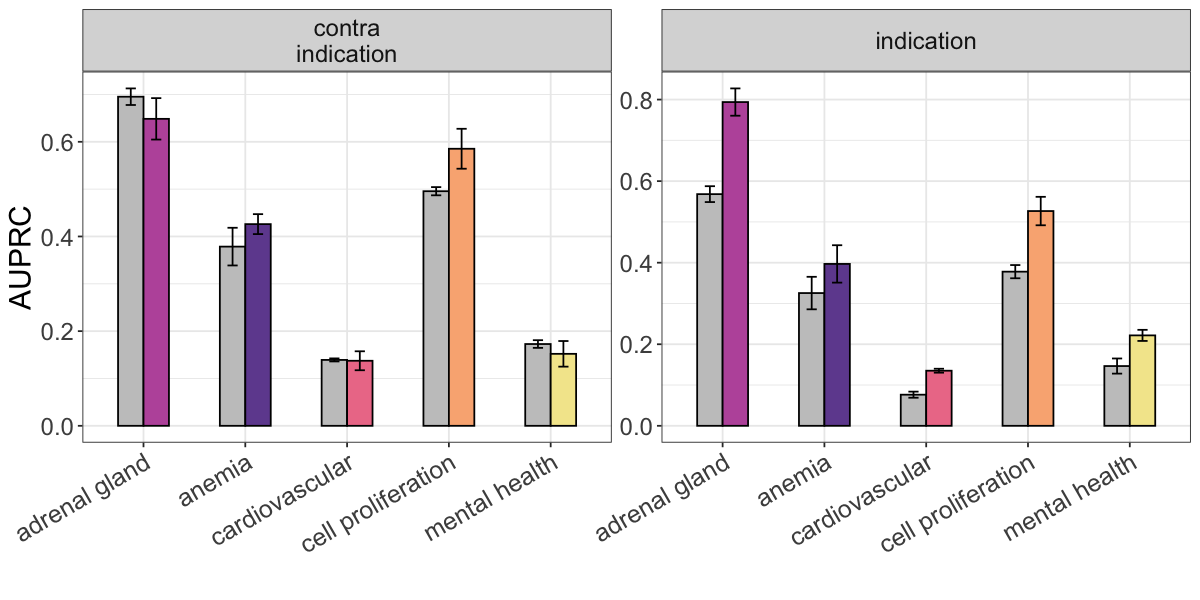

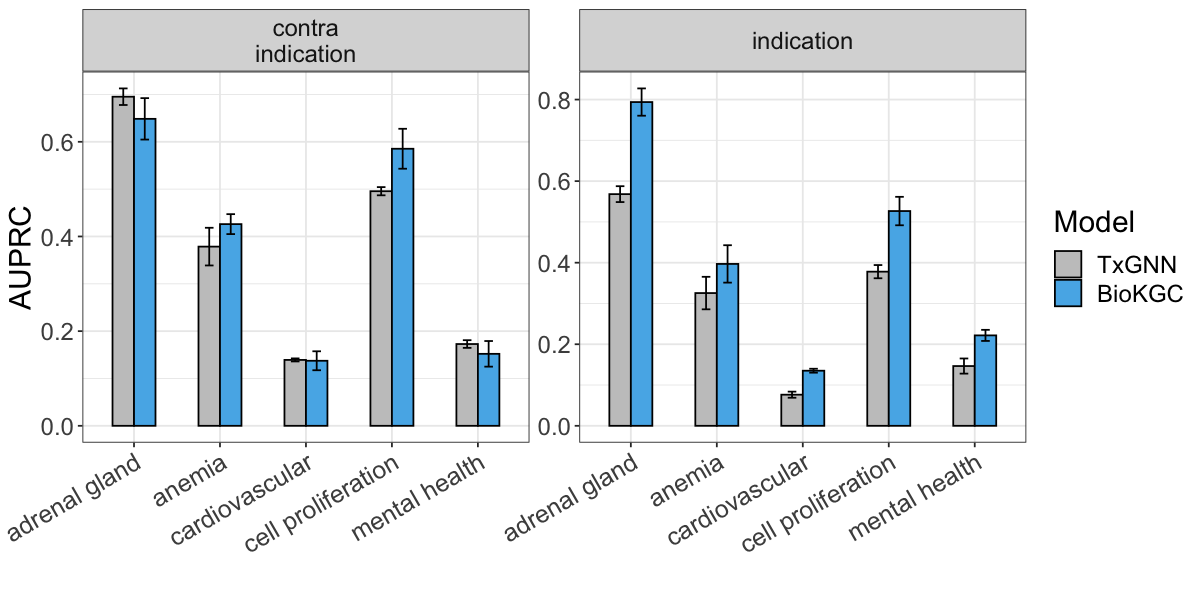

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5)
cols=c("#c6c6c6", "#56B4E9")
mymetric="AUPRC"
data_std = rbind(get_std(mymetric, "anemia"), get_std(mymetric, "adrenal_gland"), get_std(mymetric, "cardiovascular"),
      get_std(mymetric, "cell_proliferation"), get_std(mymetric, "mental_health"))

data_std$disease_area <- gsub("_", " ", data_std$disease_area)
data_std[, rel_dis:=paste0(model, "_", disease_area)]
data_std$rel_dis = factor(data_std$rel_dis, levels=unique(data_std$rel_dis))

data_std$rel=as.factor(data_std$rel)
auprc_bar_2 = ggplot(data_std, aes(x=disease_area, y=mean, fill=rel_dis)) + 
  geom_bar(stat="identity", color="black", 
           position=position_dodge(), width=0.5) +
  geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2,
                 position=position_dodge(.5)) +
  theme_bw() +
  facet_wrap(~rel, scales="free") +
  #facet_grid(rel~disease_area, scales="free") +
    #scale_fill_manual(values = cols) +
    scale_fill_manual(values = mycols) +
   theme(text = element_text(size=18), axis.text.x = element_text(size = 15, angle=30, hjust=1))+
       labs( x="", y="AUPRC") + 
       theme(legend.position="none")+
    guides(fill=guide_legend(title="Model"));auprc_bar_2

  data_std$rel=as.factor(data_std$rel)
auprc_bar = ggplot(data_std, aes(x=disease_area, y=mean, fill=model)) + 
  geom_bar(stat="identity", color="black", 
           position=position_dodge(), width=0.5) +
  geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2,
                 position=position_dodge(.5)) +
  theme_bw() +
  facet_wrap(~rel, scales="free") +
  #facet_grid(rel~disease_area, scales="free") +
    scale_fill_manual(values = cols) +
    #coord_cartesian(ylim=c(0.5, 0.9))+
   theme(text = element_text(size=18), axis.text.x = element_text(size = 15, angle=30, hjust=1))+
       labs( x="", y="AUPRC") + 
    guides(fill=guide_legend(title="Model"));auprc_bar

In [12]:
data_std

model,rel,mean,sd,disease_area,rel_dis
<fct>,<fct>,<dbl>,<dbl>,<chr>,<fct>
TxGNN,contra indication,0.37856820,0.039814095,anemia,TxGNN_anemia
TxGNN,indication,0.32551615,0.039858827,anemia,TxGNN_anemia
BioKGC,contra indication,0.42608782,0.021066410,anemia,BioKGC_anemia
BioKGC,indication,0.39696296,0.045859138,anemia,BioKGC_anemia
TxGNN,contra indication,0.69526775,0.017506368,adrenal gland,TxGNN_adrenal gland
TxGNN,indication,0.56810695,0.019459967,adrenal gland,TxGNN_adrenal gland
BioKGC,contra indication,0.64849711,0.043760301,adrenal gland,BioKGC_adrenal gland
BioKGC,indication,0.79388143,0.033456203,adrenal gland,BioKGC_adrenal gland
TxGNN,contra indication,0.13919408,0.003214647,cardiovascular,TxGNN_cardiovascular


In [13]:
base_data = get_std_on_diff("AUPRC")
base_data_plt = rbind(get_std_wo_model(mymetric, "anemia", base_data), get_std_wo_model(mymetric, "adrenal_gland", base_data), get_std_wo_model(mymetric, "cardiovascular", base_data),
      get_std_wo_model(mymetric, "cell_proliferation", base_data), get_std_wo_model(mymetric, "mental_health", base_data))

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


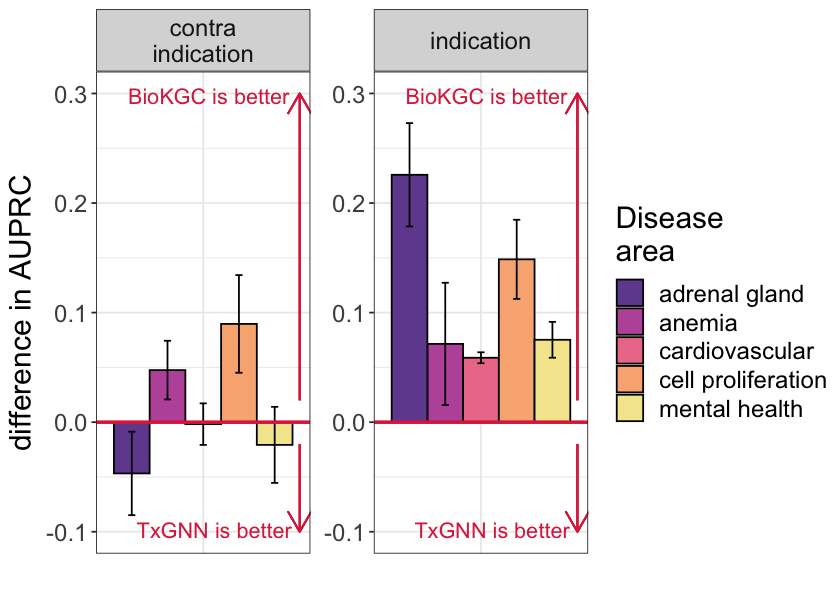

In [14]:
options(repr.plot.width = 7, repr.plot.height = 5)

base_data_plt$disease_area <- gsub("_", " ", base_data_plt$disease_area)

custom_x=1.54
custom_y=0.02
grob =   grobTree(textGrob(paste0(newname_nbfnet, " is better"), x=0.15,  y=0.95, hjust=0,
  gp=gpar(col="#dd2d4a", fontsize=13))) 
grob2 = grobTree(textGrob("TxGNN is better", x=0.19,  y=0.05, hjust=0,
  gp=gpar(col="#dd2d4a", fontsize=13))) 
base_data_plt$rel=as.factor(base_data_plt$rel)
diff_auprc = ggplot(base_data_plt, aes(x=rel, y=mean, fill=disease_area)) + 
  geom_bar(stat="identity", color="black", 
           position=position_dodge(), width=1) +
  geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2,
                 position=position_dodge(1)) +
  theme_bw() +
  #facet_wrap(~rel, scales="free") +
  #facet_grid(rel~disease_area, scales="free") +
  scale_fill_manual(values = c('#704D9E','#BC5AA9','#ED7C97','#F9B282','#F3E79A')) +

  # line at 0
  geom_hline(yintercept=0,  color = "#dd2d4a", size=1) +

  # add text
  annotation_custom(grob) + annotation_custom(grob2) +
geom_segment(aes(x = custom_x, y = custom_y, xend = custom_x, yend = 0.3),
                  arrow = arrow(length = unit(0.5, "cm")),col="#dd2d4a")+
geom_segment(aes(x = custom_x, y = -custom_y, xend = custom_x, yend = -0.1),
                  arrow = arrow(length = unit(0.5, "cm")),col="#dd2d4a")+

  theme(text = element_text(size=18), axis.text.x=element_blank(), axis.ticks.x=element_blank())+ #axis.text.x = element_text(size = 15, angle=0, hjust=0.5),)+
  labs( x="", y="difference in AUPRC") + 
  facet_wrap(~rel, scales="free") +
  guides(fill=guide_legend(title="Disease\narea"));diff_auprc

In [15]:
base_data_plt[, mean_100 := mean]
base_data_plt[rel=="indication"]
base_data_plt[rel=="contra\nindication"]

rel,mean,sd,disease_area,mean_100
<fct>,<dbl>,<dbl>,<chr>,<dbl>
indication,0.07144680,0.055780901,anemia,0.07144680
indication,0.22577448,0.047184816,adrenal gland,0.22577448
indication,0.05879520,0.004989336,cardiovascular,0.05879520
indication,0.14863458,0.036101799,cell proliferation,0.14863458
indication,0.07520086,0.016361990,mental health,0.07520086


rel,mean,sd,disease_area,mean_100
<fct>,<dbl>,<dbl>,<chr>,<dbl>
contra indication,0.047519625,0.02678059,anemia,0.047519625
contra indication,-0.046770644,0.03809345,adrenal gland,-0.046770644
contra indication,-0.001784301,0.01895644,cardiovascular,-0.001784301
contra indication,0.089689826,0.04457880,cell proliferation,0.089689826
contra indication,-0.020720537,0.03471692,mental health,-0.020720537


In [28]:
data[metric_x=="Recall"][is.na(perc)]

V1,idx,metric,mean,std,model,rel,metric_x,k,perc,seed,disease_area
<int>,<int>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
27,27,Recall@1,0.007945906,0.005060954,TxGNN,contra indication,Recall,1,NA,42,adrenal_gland
32,32,Recall@10,0.204459055,0.171963838,TxGNN,contra indication,Recall,10,NA,42,adrenal_gland
37,37,Recall@20,0.325584777,0.201509135,TxGNN,contra indication,Recall,20,NA,42,adrenal_gland
42,42,Recall@30,0.446710499,0.232242208,TxGNN,contra indication,Recall,30,NA,42,adrenal_gland
47,47,Recall@40,0.526169554,0.196869961,TxGNN,contra indication,Recall,40,NA,42,adrenal_gland
52,52,Recall@50,0.605628609,0.169415969,TxGNN,contra indication,Recall,50,NA,42,adrenal_gland
57,57,Recall@100,0.794616519,0.135530294,TxGNN,contra indication,Recall,100,NA,42,adrenal_gland
27,27,Recall@1,0.054166667,0.054803943,TxGNN,indication,Recall,1,NA,42,adrenal_gland
32,32,Recall@10,0.855555556,0.237788162,TxGNN,indication,Recall,10,NA,42,adrenal_gland


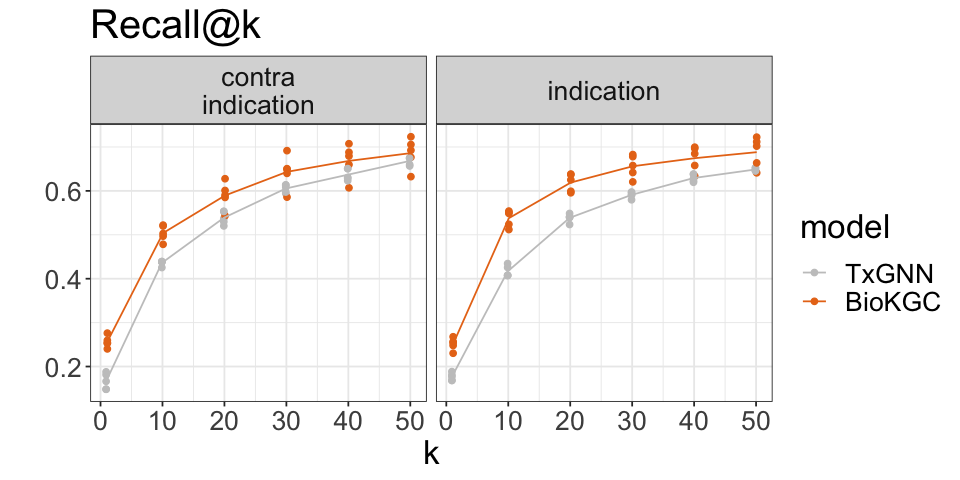

In [20]:
plot_k_plots <- function(mymetric){
   plt_data_recall = data[metric_x==mymetric][(is.na(perc))][k!=100]
   nrow(plt_data_recall)
   plt_data_recall$model <- factor(plt_data_recall$model, c("TxGNN", newname_nbfnet))
   plt_data_recall$k <- as.integer(plt_data_recall$k)
   plt_data_recall$seed <- as.factor(plt_data_recall$seed)
   plt_data_recall[,.N, by=k]
   plt_data_recall[, model_seed:=paste0(model, '-', seed)]
   options(repr.plot.width = 8, repr.plot.height = 4)

   pd = position_jitterdodge(dodge.width = 0.4, jitter.width = 0)

   cols= c("#c6c6c6","#E87519")
   plt3 = ggplot(plt_data_recall[disease_area=="cell_proliferation"], aes(x=k, y=mean, color=model)) + 
   #geom_boxplot(alpha=0.9, outlier.shape = NA, width=0.4)+
   geom_point(aes(color = model),position = pd) +
      scale_fill_manual(values = cols) + 
      scale_colour_manual(values = cols) + 
      labs(title=paste0(mymetric,"@k"), x="k", y="") + 
      theme_bw()+
      stat_summary(
      fun = mean,
      geom = 'line',
      aes(group = model, colour = model),
      position = pd )+ #this has to be added
      facet_grid(.~rel)+
   #       facet_wrap(~rel, scales="free") +

      theme(text = element_text(size=20), axis.text.x = element_text(angle=0, hjust=0.5))+ 
      theme(legend.position="right")
      return(plt3)
}


#plot_k_plots("MRR")
#plot_k_plots("AP")
plot_k_plots("Recall")

In [21]:
plt3 = plot_k_plots("Recall")

The increase expressed as percentage

In [17]:
df_mean = data[,mean(mean), by=.(model, disease_area, rel, metric)][disease_area%in%"cell_proliferation"][metric%in%c("AUPRC", "Specificity", "F1", "Recall@10")]
df_mean %>%
    group_by(metric, rel) %>%
    mutate(deltaC = ((V1 - V1[model == 'TxGNN'])/V1[model == 'TxGNN'])*100)

model,disease_area,rel,metric,V1,deltaC
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>
TxGNN,cell_proliferation,contra indication,AUPRC,0.4956297,0.0000000
TxGNN,cell_proliferation,contra indication,Specificity,0.9908523,0.0000000
TxGNN,cell_proliferation,contra indication,F1,0.3295711,0.0000000
TxGNN,cell_proliferation,contra indication,Recall@10,0.4359666,0.0000000
TxGNN,cell_proliferation,indication,AUPRC,0.3779912,0.0000000
TxGNN,cell_proliferation,indication,Specificity,0.9793158,0.0000000
TxGNN,cell_proliferation,indication,F1,0.1830720,0.0000000
TxGNN,cell_proliferation,indication,Recall@10,0.4165339,0.0000000
BioKGC,cell_proliferation,contra indication,AUPRC,0.5853195,18.0961374


In [38]:
df_mean = data[,mean(mean), by=.(model, disease_area, rel, metric)][disease_area%in%"cell_proliferation"][metric%in%c("AUPRC", "Specificity", "F1", "Recall@20")]
df_mean %>%
    group_by(metric, rel) %>%
    mutate(deltaC = ((V1 - V1[model == 'TxGNN'])/V1[model == 'TxGNN'])*100)

model,disease_area,rel,metric,V1,deltaC
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>
TxGNN,cell_proliferation,contra indication,AUPRC,0.4956297,0.0000000
TxGNN,cell_proliferation,contra indication,Specificity,0.9908523,0.0000000
TxGNN,cell_proliferation,contra indication,F1,0.3295711,0.0000000
TxGNN,cell_proliferation,contra indication,Recall@20,0.5386764,0.0000000
TxGNN,cell_proliferation,indication,AUPRC,0.3779912,0.0000000
TxGNN,cell_proliferation,indication,Specificity,0.9793158,0.0000000
TxGNN,cell_proliferation,indication,F1,0.1830720,0.0000000
TxGNN,cell_proliferation,indication,Recall@20,0.5385465,0.0000000
BioKGC,cell_proliferation,contra indication,AUPRC,0.5853195,18.0961374


pdf 
  2

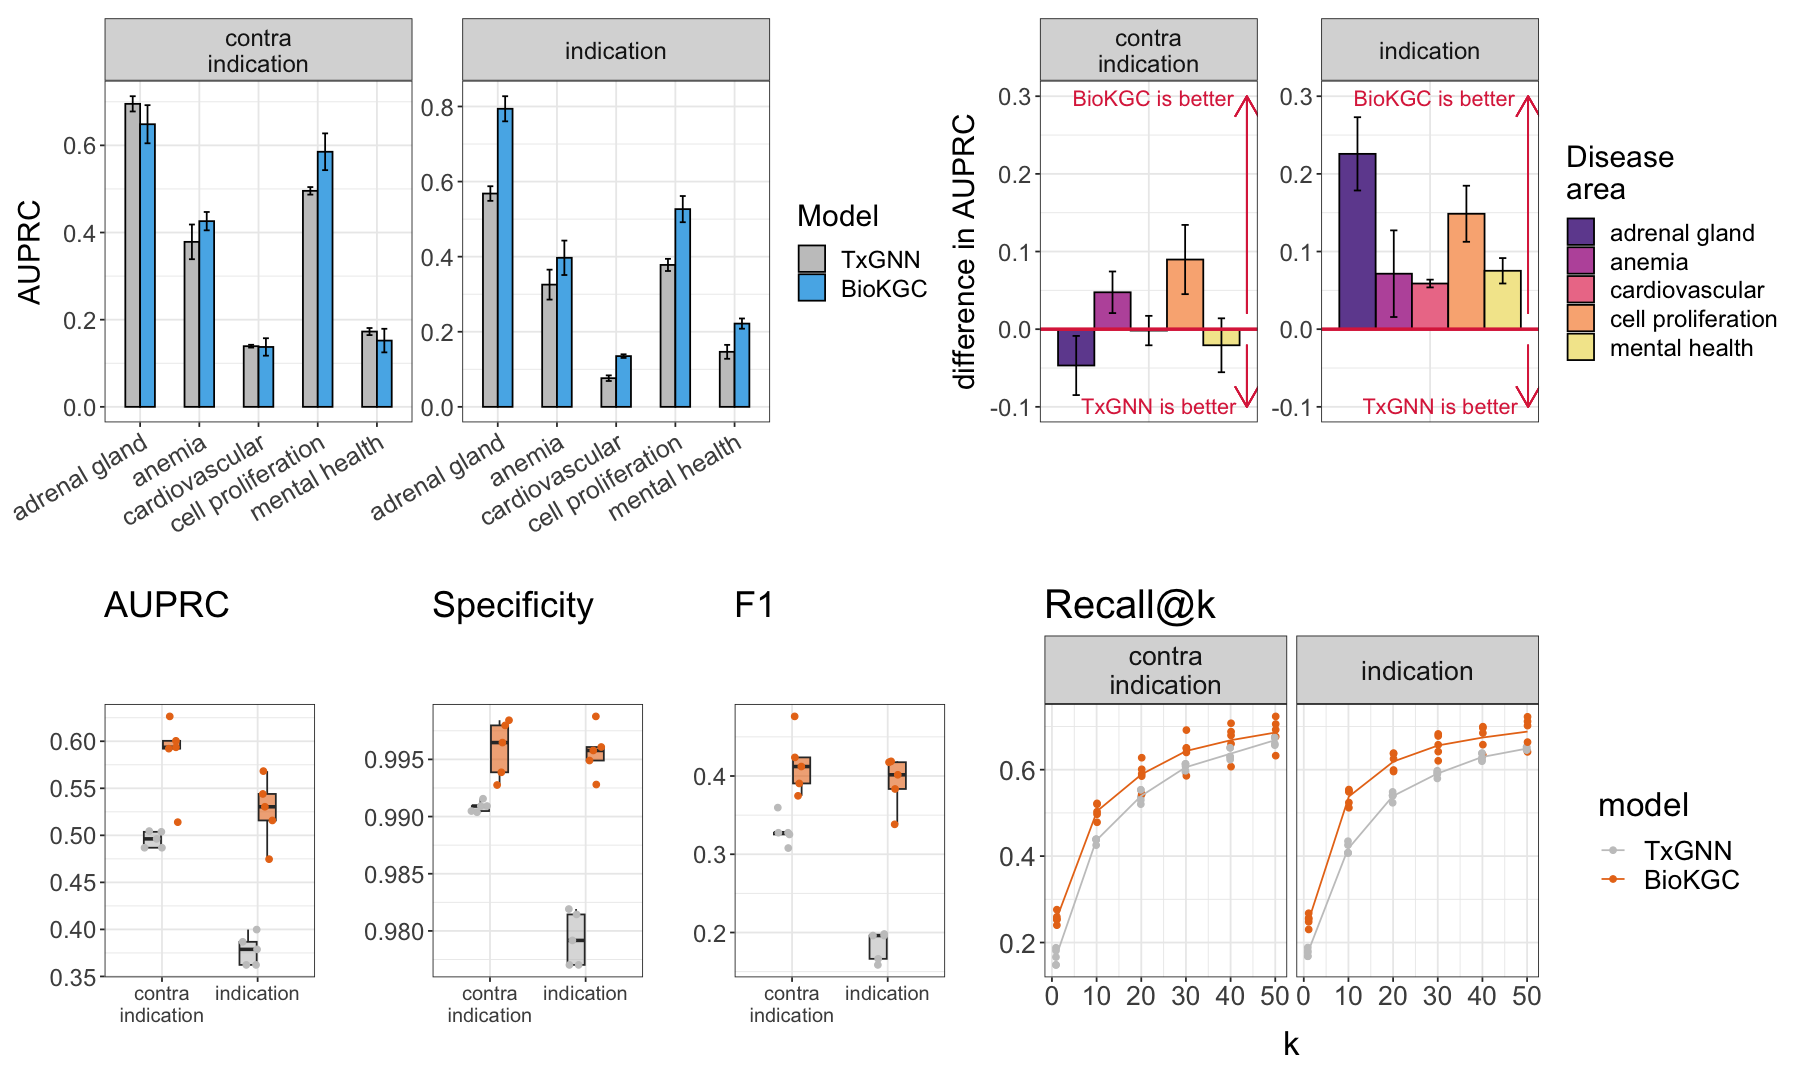

In [69]:
options(repr.plot.width = 15, repr.plot.height = 9)

pt = ((auprc_bar +  diff_auprc + plot_layout(width = c(6, 4.5)))/
        (ap + spec +f1 + plt3 + plot_layout(width = c(1,1,1,2.35))) ) + plot_layout(height = c(1,0.8))
pt# + plot_annotation(tag_levels = c('A')) &  theme(plot.tag.position = c(0, 0.955),plot.tag = element_text(size = 20, hjust = 0, vjust = 0))

pdf(paste0("//Users/yue.hu/Documents/proj/functionalannotation/analysis/perf/notebook/figs/",Sys.Date(),"BioKGC_fig_performances.pdf"), width=15, height=9)
pt
dev.off()

In [36]:
data[disease_area=="cell_proliferation"][metric=="Recall@10"][rel=="indication"][model==newname_nbfnet]

V1,idx,metric,mean,std,model,rel,metric_x,k,perc,seed,disease_area
<int>,<int>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
32,32,Recall@10,0.5539758,0.4130250,BioKGC,indication,Recall,10,NA,42,cell_proliferation
32,32,Recall@10,0.5119017,0.4086042,BioKGC,indication,Recall,10,NA,2011,cell_proliferation
32,32,Recall@10,0.5508640,0.4161464,BioKGC,indication,Recall,10,NA,14,cell_proliferation
32,32,Recall@10,0.5486504,0.4159456,BioKGC,indication,Recall,10,NA,88,cell_proliferation
32,32,Recall@10,0.5239285,0.4264396,BioKGC,indication,Recall,10,NA,314,cell_proliferation


In [37]:
data[metric=="AUPRC"][model==newname_nbfnet][rel=="indication"]

V1,idx,metric,mean,std,model,rel,metric_x,k,perc,seed
<int>,<int>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>,<dbl>
1,1,AUPRC,0.5440024,0.4066063,NBFNet,indication,AUPRC,,NA,42
1,1,AUPRC,0.4746708,0.4001615,NBFNet,indication,AUPRC,,NA,2011
1,1,AUPRC,0.5303602,0.4042682,NBFNet,indication,AUPRC,,NA,14
1,1,AUPRC,0.5682762,0.4254797,NBFNet,indication,AUPRC,,NA,88
1,1,AUPRC,0.2441338,0.3249201,NBFNet,indication,AUPRC,,NA,1618


In [39]:
data[metric=="AUPRC"][model==newname_nbfnet][rel=="indication"][disease_area=="cell_proliferation"]

V1,idx,metric,mean,std,model,rel,metric_x,k,perc,seed,disease_area
<int>,<int>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
1,1,AUPRC,0.5440024,0.4066063,BioKGC,indication,AUPRC,,NA,42,cell_proliferation
1,1,AUPRC,0.4746708,0.4001615,BioKGC,indication,AUPRC,,NA,2011,cell_proliferation
1,1,AUPRC,0.5303602,0.4042682,BioKGC,indication,AUPRC,,NA,14,cell_proliferation
1,1,AUPRC,0.5682762,0.4254797,BioKGC,indication,AUPRC,,NA,88,cell_proliferation
1,1,AUPRC,0.5158193,0.4167414,BioKGC,indication,AUPRC,,NA,314,cell_proliferation


### Get averaged performances for contraindication and indication

In [43]:
get_std_all_diseaseArea <- function(mymetric){
      data_std = rbind(get_std(mymetric, "anemia"), get_std(mymetric, "adrenal_gland"), get_std(mymetric, "cardiovascular"),
      get_std(mymetric, "cell_proliferation"), get_std(mymetric, "mental_health"))
      return(data_std)
}

get_std_all_diseaseArea_average <- function(mymetric){
      data_std = rbind(get_std(mymetric, "anemia"), get_std(mymetric, "adrenal_gland"), get_std(mymetric, "cardiovascular"),
      get_std(mymetric, "cell_proliferation"), get_std(mymetric, "mental_health"))
      data_std = get_std_all_diseaseArea(mymetric)[, mean := mean(mean), by=.(model, disease_area)]
      data_std[, sd := mean(sd), by=.(model, disease_area)]
      data_std = unique(data_std[,.(model, mean, sd, disease_area)])
      data_std[,mean:=round(mean, 3)]
      data_std
      return(data_std)
}


get_std_all_diseaseArea_plot <- function(mymetric){
      data_std = get_std_all_diseaseArea(mymetric)[, mean := mean(mean), by=.(model, disease_area)]
      
      data_std[, sd := mean(sd), by=.(model, disease_area)]
      data_std = unique(data_std[,.(model, mean, sd, disease_area)])

      data_std$disease_area <- gsub("_", " ", data_std$disease_area)
      data_std[, rel_dis:=paste0(model, "_", disease_area)]
      data_std$rel_dis = factor(data_std$rel_dis, levels=unique(data_std$rel_dis))

      data_std$rel=as.factor(data_std$rel)

      data_std$rel=as.factor(data_std$rel)
      auprc_bar = ggplot(data_std, aes(x=disease_area, y=mean, fill=model)) + 
      geom_bar(stat="identity", color="black", 
            position=position_dodge(), width=0.5) +
      geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2,
                  position=position_dodge(.5)) +
      theme_bw() +
      #facet_wrap(~rel, scales="free") +
      #facet_grid(rel~disease_area, scales="free") +
      scale_fill_manual(values = cols) +
      #coord_cartesian(ylim=c(0.5, 0.9))+
      theme(text = element_text(size=18), axis.text.x = element_text(size = 15, angle=30, hjust=1))+
            labs( x="", y=mymetric) + 
      guides(fill=guide_legend(title="Model"))
      return(auprc_bar)
}


In [46]:
get_std_all_diseaseArea_average("AUPRC")

In [47]:
mymetrics <- c("Recall@20", "AP@20","MRR@20", "F1",  "AUPRC_1:1","AUPRC", "Accuracy")

df = rbindlist(lapply(mymetrics, get_std_all_diseaseArea_average),  idcol = "metric" )
df[, metric := factor(metric, labels = mymetrics)]
df_dcast = dcast(df, disease_area + model ~ metric, value.var = "mean")
df_dcast

disease_area,model,Recall@20,AP@20,MRR@20,F1,AUPRC_1:1,AUPRC,Accuracy
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
adrenal_gland,TxGNN,0.604,0.724,0.725,0.612,0.587,0.632,0.986
adrenal_gland,BioKGC,0.562,0.903,0.900,0.405,0.582,0.721,0.971
anemia,TxGNN,0.450,0.457,0.535,0.244,0.667,0.352,0.975
anemia,BioKGC,0.504,0.493,0.520,0.305,0.674,0.412,0.979
cardiovascular,TxGNN,0.100,0.170,0.199,0.059,0.606,0.108,0.962
cardiovascular,BioKGC,0.166,0.230,0.249,0.074,0.605,0.136,0.976
cell_proliferation,TxGNN,0.539,0.487,0.549,0.256,0.811,0.437,0.983
cell_proliferation,BioKGC,0.604,0.626,0.654,0.404,0.813,0.556,0.992
mental_health,TxGNN,0.167,0.228,0.264,0.112,0.617,0.160,0.955


### How much better is BioKGC compared to TxGNN?

In [50]:
diff_all_metrics = cbind(df[model=="BioKGC"][,.(metric,disease_area)], (df[model=="BioKGC", mean] - df[model=="TxGNN", mean])*100)
dcast(diff_all_metrics, disease_area  ~ metric, value.var = "V2")

disease_area,Recall@20,AP@20,MRR@20,F1,AUPRC_1:1,AUPRC,Accuracy
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
adrenal_gland,-4.2,17.9,17.5,-20.7,-0.5,8.9,-1.5
anemia,5.4,3.6,-1.5,6.1,0.7,6.0,0.4
cardiovascular,6.6,6.0,5.0,1.5,-0.1,2.8,1.4
cell_proliferation,6.5,13.9,10.5,14.8,0.2,11.9,0.9
mental_health,5.2,3.7,3.3,2.0,-4.7,2.7,2.2


How much better if taking the sum: so how much is BioKGC better summed over contraindication and indication

In [52]:
diff_all_metrics = cbind(df[model=="BioKGC"][,.(metric,disease_area)], (df[model=="BioKGC", mean] - df[model=="TxGNN", mean])*100)
dcast(diff_all_metrics, disease_area  ~ metric, value.var = "V2")

disease_area,Recall@20,AP@20,MRR@20,F1,AUPRC_1:1,AUPRC,Accuracy
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
adrenal_gland,-4.2,17.9,17.5,-20.7,-0.5,8.9,-1.5
anemia,5.4,3.6,-1.5,6.1,0.7,6.0,0.4
cardiovascular,6.6,6.0,5.0,1.5,-0.1,2.8,1.4
cell_proliferation,6.5,13.9,10.5,14.8,0.2,11.9,0.9
mental_health,5.2,3.7,3.3,2.0,-4.7,2.7,2.2


In [53]:
df[disease_area=="cell_proliferation"][order(model)] %>%
    group_by(metric, model) %>%
    mutate(deltaC = ((mean - mean[model == 'TxGNN'])))

metric,model,mean,sd,disease_area,deltaC
<fct>,<fct>,<dbl>,<dbl>,<chr>,<dbl>
Recall@20,TxGNN,0.539,0.011896953,cell_proliferation,0.000
AP@20,TxGNN,0.487,0.013917098,cell_proliferation,0.000
MRR@20,TxGNN,0.549,0.018070843,cell_proliferation,0.000
F1,TxGNN,0.256,0.018846357,cell_proliferation,0.000
AUPRC_1:1,TxGNN,0.811,0.028256869,cell_proliferation,0.000
AUPRC,TxGNN,0.437,0.012430706,cell_proliferation,0.000
Accuracy,TxGNN,0.983,0.001344910,cell_proliferation,0.000
Recall@20,BioKGC,0.604,0.025483066,cell_proliferation,0.065
AP@20,BioKGC,0.626,0.035760873,cell_proliferation,0.139


In [61]:
df[order(model)][metric=="AUPRC"] %>%
    group_by(metric, model) %>%
    mutate(deltaC = ((mean - mean[model == 'TxGNN'])/mean[model == 'TxGNN'])*100) %>% setDT  %>%
    .[model=="BioKGC"] %>% .$deltaC %>% mean

[1] 20.23196